In [1]:
from physical_models import Annular
from bias_models import *
from run import main
from create import *
from plot_functions.plotResults import *


if os.path.isdir('/mscott/'):
    os.chdir('/mscott/an553/')  # set working directory to mscott

folder = 'results/Annular/'
figs_dir = folder + 'figs/'

os.makedirs(figs_dir, exist_ok=True)

%% ==================================== SELECT TRUE MODEL ======================================= #

In [2]:
ERs = 0.4875 + np.arange(0, 8) * 0.0125  # equivalence ratios 0.4875-0.575 (by steps of 0.0125)
ER = ERs[-1]

true_params = {'model': 'annular/ER_{}'.format(ER),
               'std_obs': 0.01
               }



%% ==================================== SELECT FILTER PARAMETERS =================================== #

In [3]:
parameters_IC = dict(
        nu=(40., 50.), 
        beta_c2=(40., 50.),
        kappa=(1.E-4, 1.3E-4),
        epsilon=(1E-3, 5E-3),
        omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
        theta_b=(0.5, 0.7),
        theta_e=(0.4, 0.8),
)

filter_params = {'filter': 'rBA_EnKF',  # 'rBA_EnKF' 'EnKF' 'EnSRKF'
                 'constrained_filter': False,
                 'regularization_factor': 0.,
                 'm': 10,
                 # Parameter estimation options
                 'est_a': [*parameters_IC],
                 'std_a': parameters_IC,
                 'alpha_distr': 'uniform',
                 'std_psi': .5,
                 # Define the observation time window
                 't_start': 1.0,
                 't_stop': 1.05,
                 'dt_obs': 60,
                 # Inflation
                 'inflation': 1.00,
                 'reject_inflation': 1.00
                 }

truth = create_truth(true_params, filter_params, post_processed=False)

Plot truth 

 %% ================================= SELECT FORECAST MODEL ===================================== #

In [4]:
# These are the values from NN's code

k = 1.2e-4
nu_1 = 633.77
nu_2 = -331.39
c2b_1 = 258.3
c2b_2 = -108.27

omega = 1090 * 2 * np.pi

# initial values
C0 = 10
X0 = 0
th0 = 0.63
ph0 = 0

# Conversion of the initial conditions from the quaternion formalism to the AB formalism
Ai = C0 * np.sqrt(np.cos(th0)**2 * np.cos(X0)**2 + np.sin(th0)**2 * np.sin(X0)**2)
Bi = C0 * np.sqrt(np.sin(th0)**2 * np.cos(X0)**2 + np.cos(th0)**2 * np.sin(X0)**2)
phai = ph0 + np.arctan2(np.sin(th0) * np.sin(X0), np.cos(th0) * np.cos(X0))
phbi = ph0 - np.arctan2(np.cos(th0) * np.sin(X0), np.sin(th0) * np.cos(X0))

# initial conditions for the fast oscillator equations psi = [eta_a; deta_a; eta_b; deta_b]
psi0 = [Ai * np.cos(phai), 
        -omega * Ai * np.sin(phai), 
        Bi * np.cos(phbi), 
        -omega * Bi * np.sin(phbi)]

forecast_params = {'model': Annular,
                   'dt': truth['dt'],
                   'nu': nu_1*ER + nu_2,
                   'beta_c2': c2b_1*ER + c2b_2,
                   'omega': omega,
                   'psi0': psi0
                   }



 %% ================================= SELECT BIAS MODEL ===================================== #

In [5]:
bias_params = {'biasType': NoBias,  # Bias.ESN / Bias.NoBias
               'std_a': filter_params['std_a'],
               'est_a': filter_params['est_a'],
               'augment_data': True,
               'upsample': 5,
               'L': 10,
               'N_wash': 20,
               'noise': 0.01,
               'rho_range': (0.5, 1.1),
               'sigma_in_range': (np.log10(1e-5), np.log10(1e0)),
               'tikh_range': [1e-16],
               }

 %% ================================= CORE OF THE CODE ===================================== #

In [6]:

ensemble = create_ensemble(forecast_params, filter_params)
filter_ens = ensemble.copy()

truth = create_truth(true_params, filter_params)


# START BIAS MODEL -----------------------------------------------------------
ESN_name = 'ESN_{}_L{}'.format(truth['name_bias'], bias_params['L'])
create_bias_model(filter_ens, truth, bias_params, ESN_name,
                  bias_model_folder=folder, plot_train_data=True)

# Add washout if needed ------------------------------------------------------

filter_ens = main(filter_ens, truth)




 ------------------ Annular Model Parameters ------------------ 
	 Nq = 4
	 beta_c2 = 45.0
	 epsilon = 0.003
	 kappa = 0.000115
	 n = 1.0
	 nu = 45.0
	 omega = 6864.38
	 theta_b = 0.6
	 theta_e = 0.6

 ----------------  Bias model parameters ----------------  
 Bias model: None

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = None 
 	 m = 10 
 	 Time steps between analysis = 60 
 	 Inferred params = ['nu', 'beta_c2', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.5
 	 Ensemble std(alpha0) = {'nu': (40.0, 50.0), 'beta_c2': (40.0, 50.0), 'kappa': (0.0001, 0.00013), 'epsilon': (0.001, 0.005), 'omega': (6848.671984825749, 6880.087911361647), 'theta_b': (0.5, 0.7), 'theta_e': (0.4, 0.8)}
 	 Number of analysis steps = 43, t0=0.99998046875, t1=1.04919921875
	 Bias penalisation factor k = 0.0

 --------------------------------------------
Elapsed time to first observation: 2.718090534210205 

 %% ================================= PLOT RESULTS ===================================== #

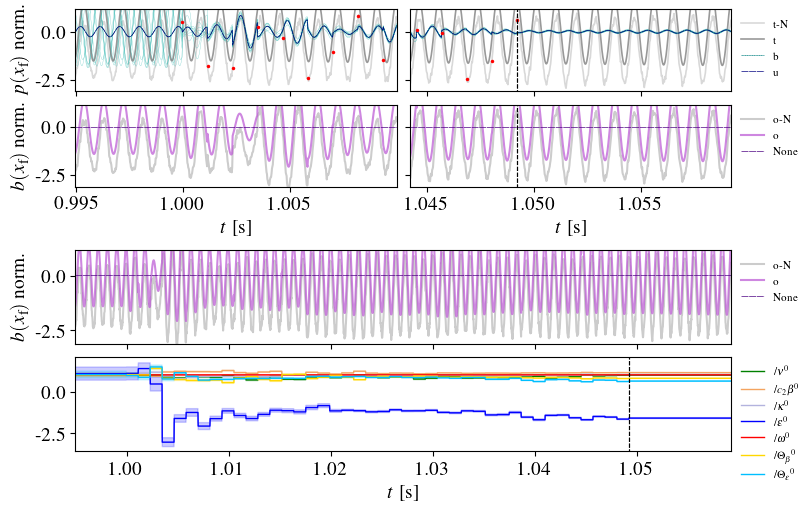

In [7]:
post_process_single(filter_ens, truth)

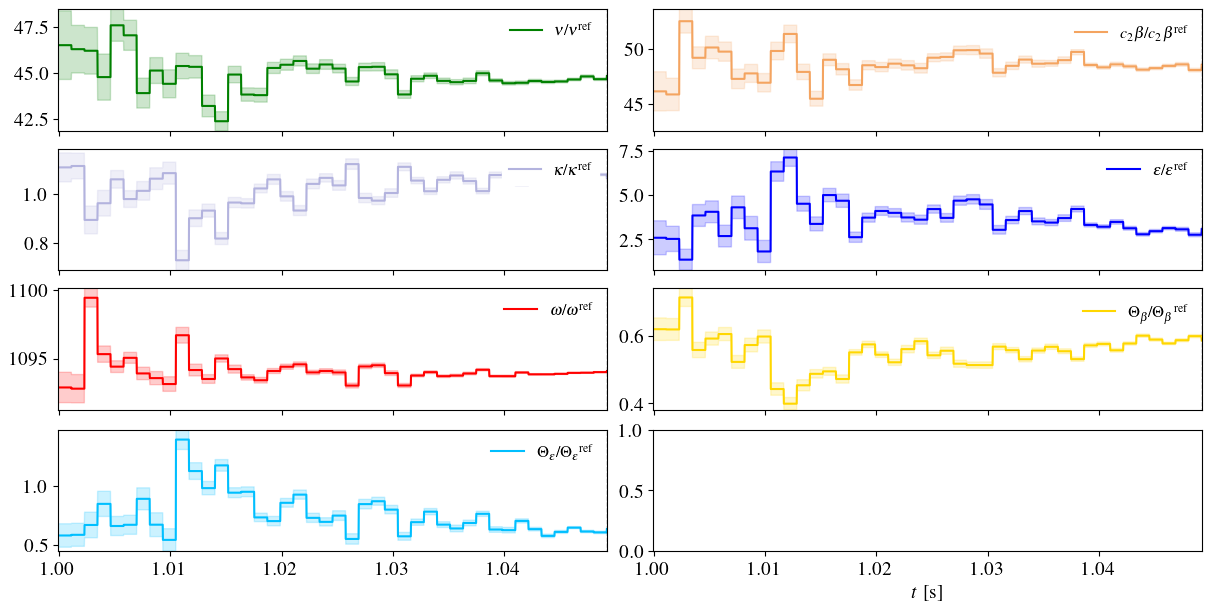

In [19]:
# Plot results -------
if filter_ens.est_a:
    reference_p = dict(omega=2 * np.pi,
                       kappa=1e-4,
                       epsilon=1e-3)

    plot_parameters(filter_ens, truth, reference_p=reference_p)


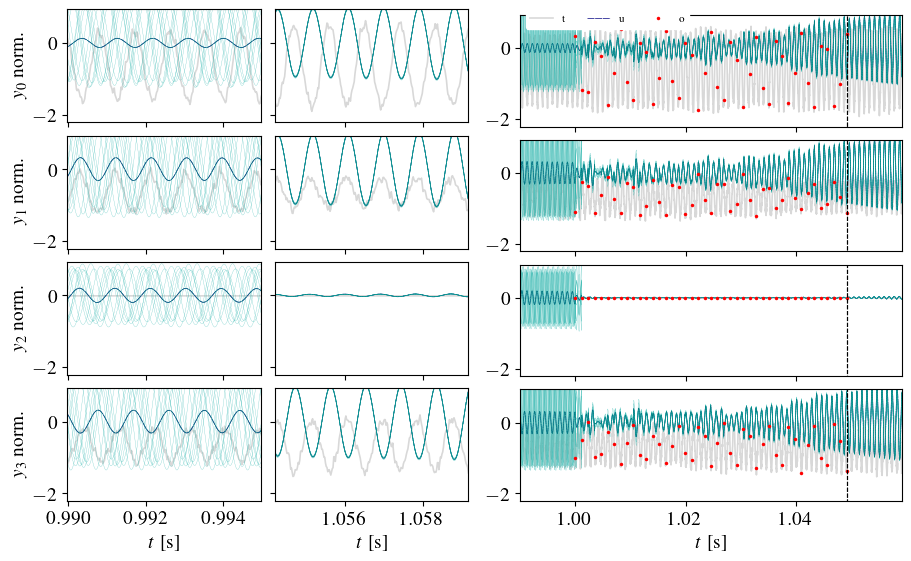

In [20]:

plot_timeseries(filter_ens, truth, reference_y=1000.)

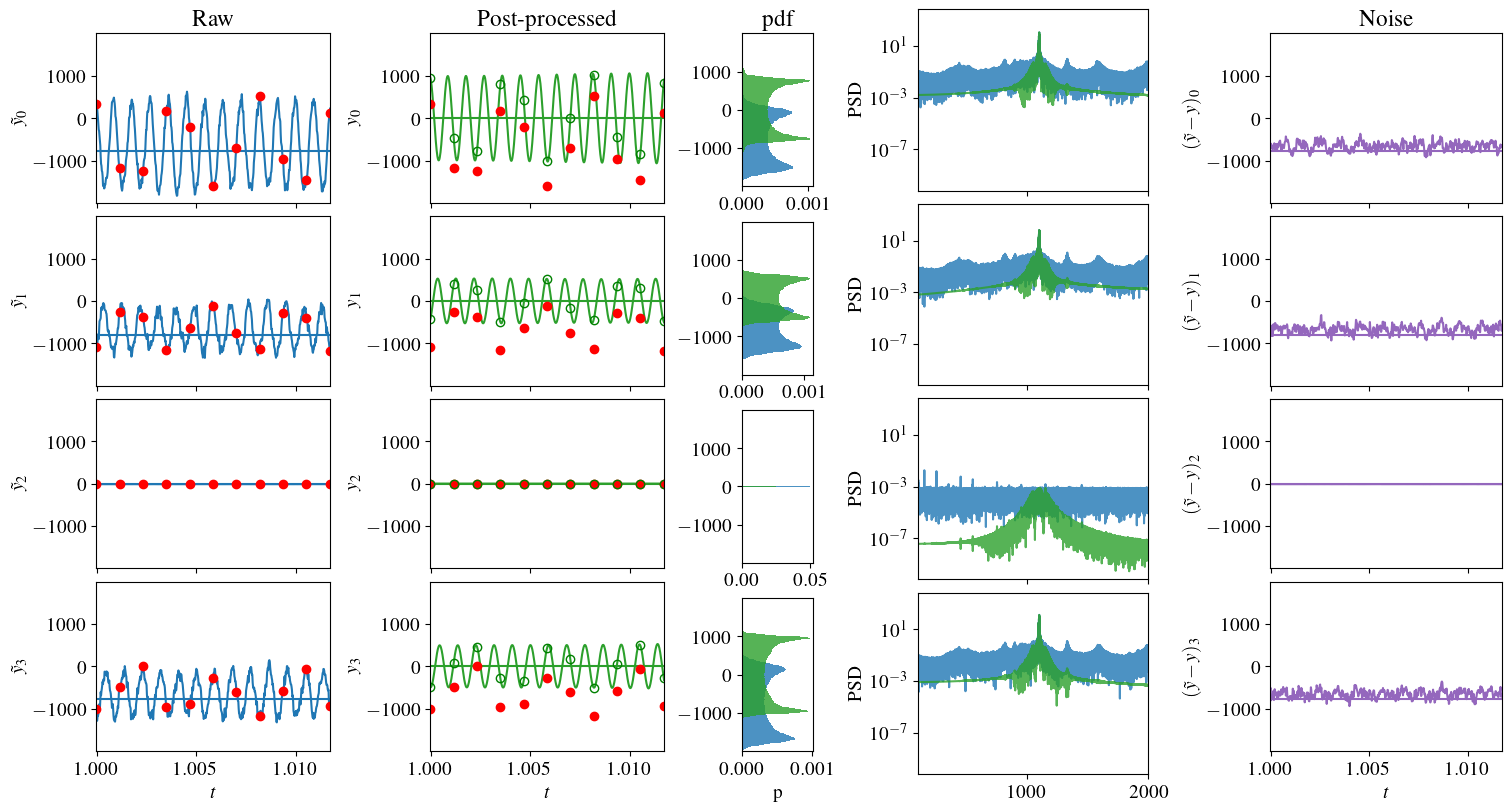

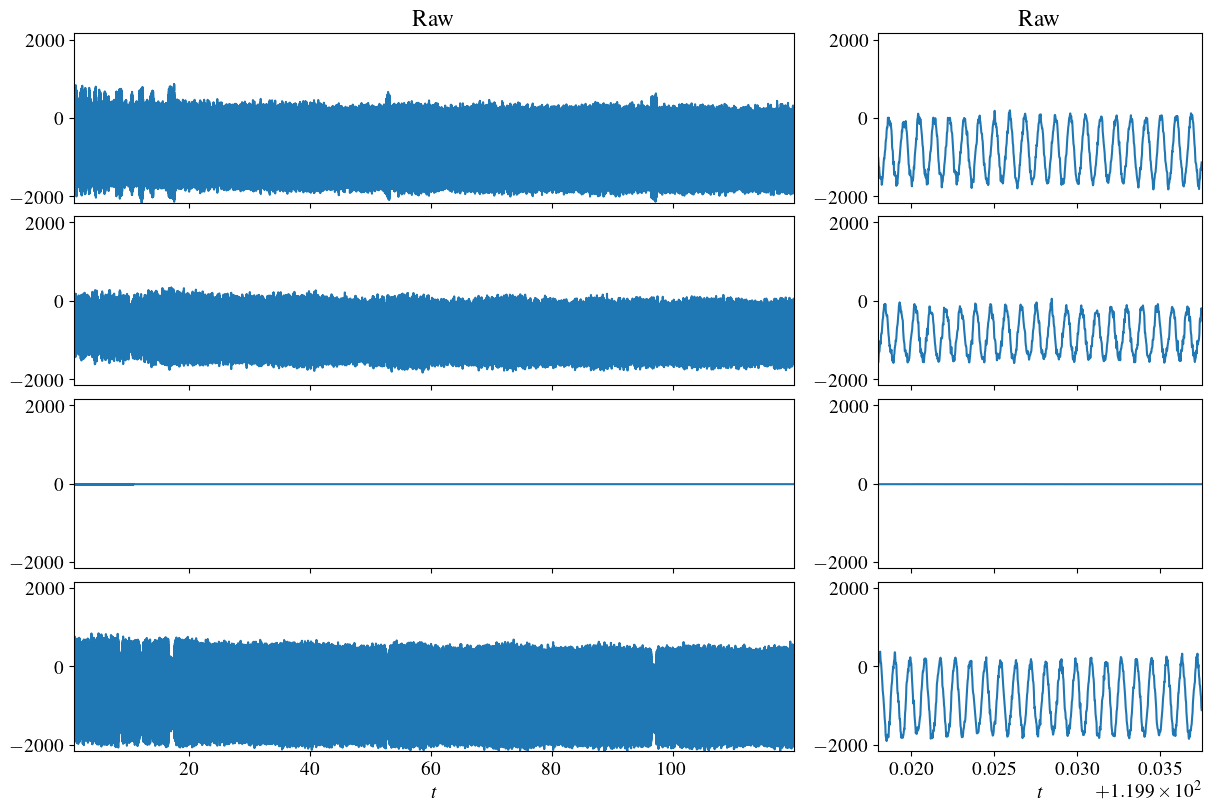

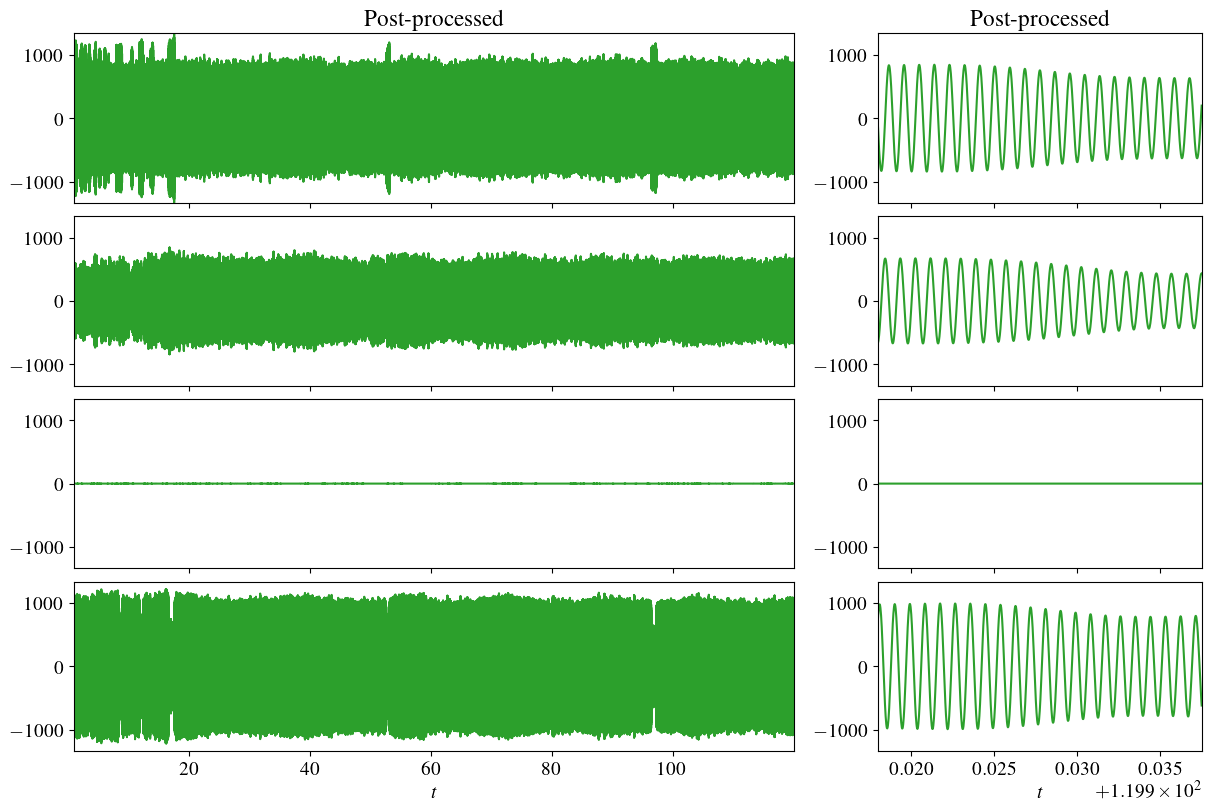

1.953125e-05
Elapsed time =  2.18221378326416


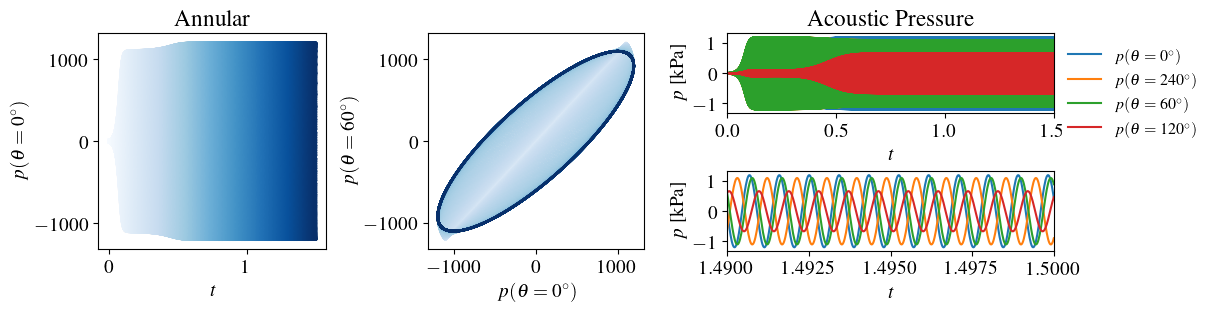

In [21]:
# Plot data
plot_truth(truth, plot_time=True, Nq=4)
plot_annular_model(forecast_params)